In [4]:
from datasets import load_dataset
import matplotlib.pyplot as plt

In [6]:
dataset = load_dataset("jxie/flickr8k")
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4'],
        num_rows: 1000
    })
})

In [7]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x399 at 0x7C498737F9A0>, 'caption_0': 'A black dog is running after a white dog in the snow .', 'caption_1': 'Black dog chasing brown dog through snow', 'caption_2': 'Two dogs chase each other across the snowy ground .', 'caption_3': 'Two dogs play together in the snow .', 'caption_4': 'Two dogs running through a low lying body of water .'}


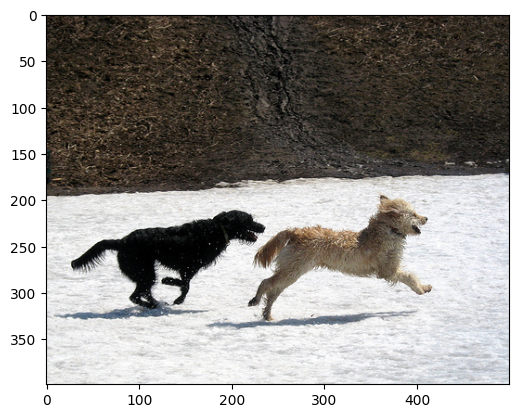

A black dog is running after a white dog in the snow .
Black dog chasing brown dog through snow
Two dogs chase each other across the snowy ground .
Two dogs play together in the snow .
Two dogs running through a low lying body of water .


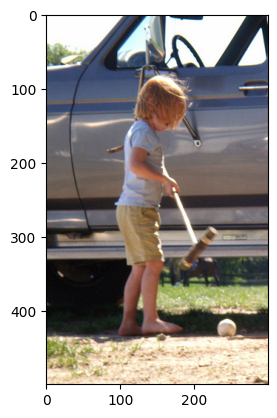

A little baby plays croquet .
A little girl plays croquet next to a truck .
The child is playing croquette by the truck .
The kid is in front of a car with a put and a ball .
The little boy is playing with a croquet hammer and ball beside the car .


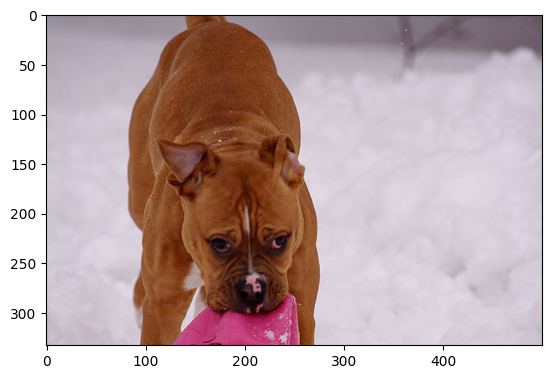

A brown dog in the snow has something hot pink in its mouth .
A brown dog in the snow holding a pink hat .
A brown dog is holding a pink shirt in the snow .
A dog is carrying something pink in its mouth while walking through the snow .
A dog with something pink in its mouth is looking forward .


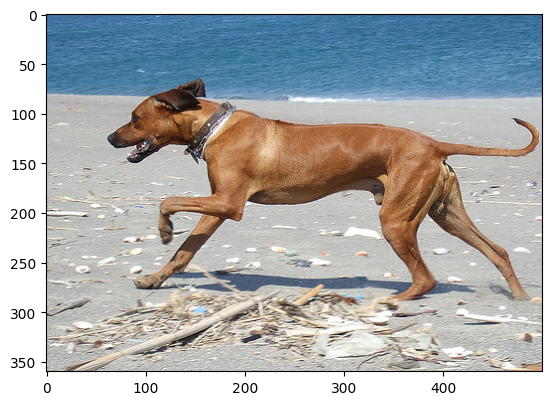

A brown dog is running along a beach .
A brown dog wearing a black collar running across the beach .
A dog walks on the sand near the water .
Brown dog running on the beach .
The large brown dog is running on the beach by the ocean .


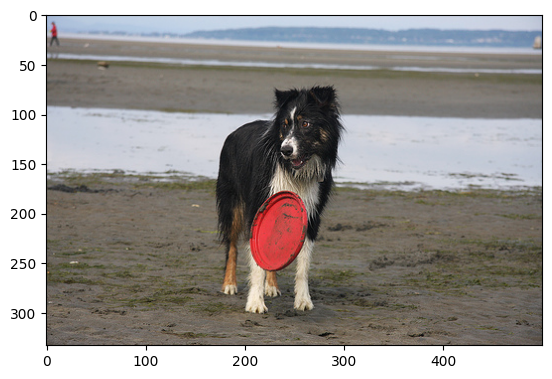

A black and white dog with a red Frisbee standing on a sandy beach .
A dog drops a red disc on a beach .
A dog with a red Frisbee flying in the air .
Dog catching a red Frisbee .
The black dog is dropping a red disc on a beach .


In [10]:
for i in range(5):
    plt.imshow(dataset["train"]["image"][i])
    plt.show()
    for j in range(5):
        print(dataset["train"][f"caption_{j}"][i])